# Tutorial 10a - Custom Surface Types

### September 2024

This tutorial shows how new surface types can be defined and used in Optiland. In general, any surface geometry can be defined in Optiland, so long as the surface equation is defined and it is differentiable.

To demonstrate this, we will generate a new surface that is defined by the following equation:

$z(x, y) = \frac{r^2}{R \cdot (1 + \sqrt{(1 - (1 + k) \cdot r^2 / R^2)})} + ar^2 + br^3 + c\sin(dr^2)$

where

- $x$ and $y$ are the local surface coordinates
- $r = \sqrt{x^2 + y^2}$
- $R$ is the radius of curvature
- $k$ is the conic constant
- $a$, $b$, $c$ and $d$ are coefficients

In this tutorial, we will generate a simple singlet lens whose first surface is defined by this equation.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from optiland import optic
from optiland.coordinate_system import CoordinateSystem
from optiland.geometries import NewtonRaphsonGeometry
from optiland.materials import IdealMaterial, Material
from optiland.surfaces import Surface

Introduction

In Optiland, an optic is defined as a collection of sequential surfaces. Each surface can be defined by the following components

- Geometry - the physical shape of the surface
- Material (pre-surface) - the material before the surface
- Material (post-surface) - the material after the surface
- Coating - optionally, a coating can be applied to the surface
- Scatter model - optionally, a scatter model can be applied to the surface.
- Physical aperture - optionally, we can specify obscurations on the surface, such as a hole in the surface center.

In general, we also specify whether the surface is the aperture stop and if the material is transmissive or reflective.

In this tutorial, we will focus on only the geometry component.

Geometry Definition

To create our custom surface, we will need to create a new geometry class that uses the surface equation defined above.

We will start by inheriting from the "NewtonRaphsonGeometry" class. This class uses the Newton-Raphson method to find ray intersection points on the surface. We simply need to define the surface sag equation (from above) and the equation for the surface normal. Every geometry requires at least a coordinate system input, but we also want to include arguments for the radius of curvature, conic constant, and the coefficients.

We define the surface equation in the "sag" method and we define the surface normal in the "_surface_normal" method. Determining the surface normal involves finding the gradient of the surface equation:

$f(x, y, z) = 0 = \frac{r^2}{R \cdot (1 + \sqrt{(1 - (1 + k) \cdot r^2 / R^2)})} + ar^2 + br^3 + c\sin(dr^2) - z$

In [2]:
class NewGeometry(NewtonRaphsonGeometry):
    def __init__(self, coordinate_system, radius, conic, a, b, c, d):
        super().__init__(coordinate_system, radius, conic=0.0, tol=1e-10, max_iter=100)
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def sag(self, x=0, y=0):
        r2 = x**2 + y**2
        z = r2 / (self.radius * (1 + np.sqrt(1 - (1 + self.k) * r2 / self.radius**2)))

        # Here we add our new surface sag term, as defined above
        r = np.sqrt(r2)
        z += self.a * r + self.b * r**3 + self.c * np.sin(self.d * r2)

        return z

    def _surface_normal(self, x, y):
        r2 = x**2 + y**2

        # term for the standard conic surface
        denom = self.radius * np.sqrt(1 - (1 + self.k) * r2 / self.radius**2)
        dfdx = x / denom
        dfdy = y / denom
        dfdz = -1

        # term for the new surface sag term
        r = np.sqrt(r2)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dfdx += (
                self.a * x / r2
                + 3 * self.b * x * r
                + 2 * self.c * self.d * x * np.cos(self.d * r2)
            )  # df/dx
            dfdy += (
                self.a * y / r2
                + 3 * self.b * y * r
                + 2 * self.c * self.d * y * np.cos(self.d * r2)
            )  # df/dy

        # we normalize the gradient to get the normal
        mag = np.sqrt(dfdx**2 + dfdy**2 + dfdz**2)

        nx = dfdx / mag
        ny = dfdy / mag
        nz = dfdz / mag

        return nx, ny, nz

We now define our geometry. We will create a coordinate system object at the origin, which coincides with the first surface vertex. We choose arbitrary values for the radius of curvature, conic constant and coefficients.

Note: By definition, Optiland always defines the global origin at the vertex of the first surface.

In [3]:
cs = CoordinateSystem(x=0, y=0, z=0, rx=0, ry=0, rz=0, reference_cs=None)
new_geo = NewGeometry(
    coordinate_system=cs,
    radius=-513.7,
    conic=0,
    a=-7.043e-01,
    b=6.622e-05,
    c=2.142e-01,
    d=-1.110e-02,
)

Let's see what the surface looks like by plotting it in 3D.

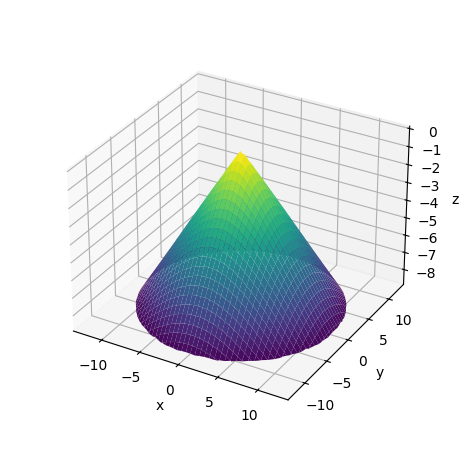

In [4]:
x = np.linspace(-12, 12, 256)
x, y = np.meshgrid(x, x)
z = new_geo.sag(x, y)  # <-- get the z values for the surface from "sag" method

# filter out points outside the aperture
r2 = x**2 + y**2
z[r2 > 12**2] = np.nan

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, z, cmap="viridis")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_box_aspect(None, zoom=0.85)  # to avoid cutting off z label
plt.tight_layout()
plt.show()

Surface Definition

Now that we've defined our geometry, we also need to define the other components of our surface. In particular, we need to define the materials on each side of the surface. As this surface is the first surface of our system, the "pre-surface" material will simply be air and the "post-surface" material we will define as Schott SF2. There are other properties of the surface that can be added, such as coatings, scattering behavior, or physical apertures, but we will ignore these.

In [5]:
material_pre = IdealMaterial(n=1.0)  # air
material_post = Material(name="SF2")

We now have all components needed to generate our surface. We will also specify this surface as the aperture stop.

In [6]:
new_surface = Surface(
    geometry=new_geo,
    material_pre=material_pre,
    material_post=material_post,
    is_stop=True,
)

Lens definition

We use the the Optiland class "Optic" to generate our lens. We pass the new surface to our optic at surface index 1, which is the first optical surface of our lens. As is typical, we define the aperture, field, and wavelength of our system. Note also that we specify the "thickness" of our surface as 15 mm. This means the distance from our custom surface to the following surface is 15 mm.

Note: Care must be taken to assure that the custom surface is properly defined in the global coordinate system. Recall that the first surface is defined as the global origin in Optiland.

In [7]:
lens = optic.Optic()

# add surfaces
lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(
    index=1,
    new_surface=new_surface,
    thickness=15,
)  # <-- new surface added here
lens.add_surface(index=2, radius=-100, thickness=50)
lens.add_surface(index=3)

# add aperture
lens.set_aperture(aperture_type="EPD", value=25)

# add field
lens.set_field_type(field_type="angle")
lens.add_field(y=0)

# add wavelength
lens.add_wavelength(value=0.55, is_primary=True)

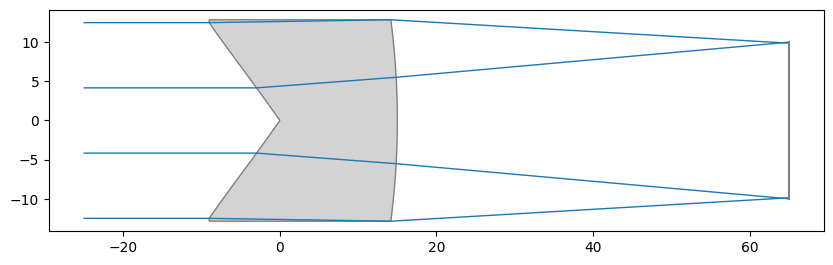

In [8]:
lens.draw(num_rays=4)

In [9]:
lens.draw3D()  # opens a new window, but we show a photo of the output below

<figure style="text-align: left;">
  <img src="../images/custom_surface.png" alt="Singlet" style="width: 700px;">
</figure>

While this lens form may not be particularly useful or practical, the concepts shown here can be used to define a surface with any desired geometry.

Conclusions

- We demonstrated how a custom surface type can be created and added to an optical system in Optiland.
- Creating a new surface type entails defining a new geometry, in which the surface sag equation and surface normal equation are defined.
- Once the custom surface is defined, it can be used like any other surface in Optiland.